# Ressources

In [1]:
import pandas as pd
import ast
import missingno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.pyplot as plt


import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn import cluster, metrics
from sklearn import manifold, decomposition

import tensorflow as tf
import keras
from keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import metrics as kmetrics
from keras.layers import *
from keras.models import Model

import tensorflow_hub as hub

# Bert
import os
import transformers
from transformers import *

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# fix pour plotly express et Visual Studio Code
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# Fonctions

## Mots

In [2]:
# https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4470548-recuperez-et-explorez-le-corpus-de-textes

def tokenizer_fct(sentence) : # découpe l'expression en liste de mot
    """
    Découpe l'expression en liste de mot
    
    La tokenization, qui désigne le découpage en mots des différents documents qui constituent votre corpus
    

    
    Parameters
    ----------
    
    sentence : :class:`str` : Phrase à découper
    
    Return
    ----------
    Liste des mots découpés
    """
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens


def compte_nombre_mots_colonne(df, colonne):
    """
    Compte le nombre de mots par ligne dans une colonne
    
    Parameters
    ----------
    
    df : :class:`dataframe` : Le dataframe
    
    colonne : :class:`colonne dataframe` : Colonne du dataframe à compter
    
    Return :
    ----------
    Le nombre de mots pour chaque ligne
    
    Exemples
    ----------
    data['length_bow'] = compte_nombre_mots_colonne(data, 'sentence_bow')
    """

    return df[colonne].apply(lambda x : len(word_tokenize(x))) #


# Stop words # génère des mots "stop", comme les pronoms, des verbes d'état, des ponctuations... Des mots dont on ne veut pas
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']


# La normalisation et la construction du dictionnaire qui permet de ne pas prendre en compte des détails importants au niveau local (ponctuation, majuscules, conjugaison, etc.) -> stopword / lemma / lower_start


def stop_word_filter_fct(list_words) :
    """
    La normalisation et la construction du dictionnaire qui permet de ne pas prendre en compte des détails importants au niveau local (ponctuation, majuscules, conjugaison, etc.)
    
    Parameters
    -----------
    
    list_words : :class:`list` : liste des mots où il faut exclure les parasites
    
    Exemples
    ----------
    stop_word = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']
    
    Return
    ---------
    Liste des mots sans les stopwords
    """
    filtered_w = [w for w in list_words if not w in stop_w] # affiche le mot de la list word s'il n'est pas dans la liste stop_w
    filtered_w2 = [w for w in filtered_w if len(w) > 2] # affiche le mot de la liste filtered_w s'il fait plus de 2 lettres
    return filtered_w2


def lemma_fct(list_words) : # Lemmatizer (base d'un mot)  # découpe l'expression en liste de lettre
    
    """
    Le processus de « lemmatisation » consiste à représenter les mots (ou « lemmes » 😉) sous leur forme canonique. 
    Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier. L'idée étant encore une fois de ne conserver que le sens des mots utilisés dans le corpus.
    Dans le processus de lemmatisation, on transforme donc « suis » en « être»  et « attentifs » en « attentif ».
    
    Parameters
    ----------
    
    list_words : :class:`list` : liste des mots (de préférence après suppression des stopwords)
    
    Return
    ----------
    Liste des mots
    """
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


def lower_start_fct(list_words) :    # lower les mots s'ils ne commencent pas par @ ou http
    """
    Lower les mots s'ils ne commencent pas par @ ou http

    Parameters
    ----------

    list_words : :class:`list` : liste des mots (de préférence après suppression des stopwords)


    Return
    ---------
    Liste des mots après lower()
    """
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw


# cours associé : https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855001-representez-votre-corpus-en-bag-of-words


def transform_word(desc_text) :
    """ Fonctions de préparation du texte pour le bag of words (Countvectorize et Tf_idf, Word2Vec) 
    
    cours associé : https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855001-representez-votre-corpus-en-bag-of-words
    
    La manière la plus simple de représenter un document, c'est ce qu'on a effectué dans le chapitre précédent où l'on a considéré tous les mots utilisés pour chaque artiste, sans distinction ni dépendance par vers, chanson, etc. 
    L'analogie est donc qu'on a considéré chaque artiste par la représentation brute d'un "sac" de tous les mots qu'il a utilisé, sans soucis de contexte (ordre, utilisation, etc).
    
    # Tf_idf :
    
    Depuis le départ, on a seulement utilisé les fréquences d'apparition des différents mots/n-grammes présents dans notre corpus. 
    Le problème est que si l'on veut vraiment représenter un document par les n-grammes qu'il contient, il faudrait le faire relativement à leur apparition dans les autres documents.

    En effet, si un mot apparait dans d'autres documents, il est donc moins représentatif du document qu'un mot qui n'apparait que uniquement dans ce document.

    Nous avons d'abord supprimé les mots les plus fréquents de manière générale dans le langage (les fameux stopwords).
    À présent, il ne faut pas considérer le poids d'un mot dans un document comme sa fréquence d'apparition uniquement, mais pondérer cette fréquence par un indicateur si ce mot est commun ou rare dans tous les documents.

    Pour résumer, le poids du n-gramme est le suivant :

    #### poids=fréquence du terme×indicateur similarité

    En l’occurence, la métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique. 
    Il est appelé logiquement « inverse document frequency » (idf). 
    
    Parameters
    ----------
    
    desc_text
    
    Return
    ----------
    
    
    Exemples
    ---------
    data_T['sentence_bow'] = data_T0['text'].apply(lambda x : transform_word(x))
    """
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


def transform_word_lem(desc_text) :
    """Fonctions de préparation du texte pour le bag of world avec lemmatization
    cours associé : https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855001-representez-votre-corpus-en-bag-of-words
    Parameters
    ----------
    
    desc_text
    
    Return
    ----------
    
    Exemples
    ----------
    # data_T['sentence_bow_lem'] = data_T0['text'].apply(lambda x : transform_word_lem(x))
    """
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

def transform_word_deeplearning(desc_text) :
    """Fonction de préparation du texte pour le Deep Lerning (USE et BERT)
    cours associé : https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855001-representez-votre-corpus-en-bag-of-words
    Parameters
    -----------
    
    desc_text
    
    Return
    -----------
    
    Exemples
    ------------
    data_T['sentence_dl'] = data_T0['text'].apply(lambda x : transform_word_deeplearning(x))
    """
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

## Communes

In [3]:
import time


def preparation_variable_discriminante(df, colonne):
    """Créer une liste avec la variable discriminante qui servira à l'ARI
    
    Parameters
    ----------
    
    df : :class:`DataFrame`
    colonne : :class:`Series` : Colonne du DataFrame qui est la variable discriminante
    
    Return
    ----------
    l_cat : Liste avec les valeurs uniques
    y_cat_num : Liste avec les numéros
    """
    l_cat = list(set(df[colonne]))  # variable discriminante pour les graphiques
    print("catégories : ", l_cat)
    y_cat_num = [(1-l_cat.index(df.iloc[i][colonne])) for i in range(len(df))]
    return l_cat, y_cat_num

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, l_cat, y_cat_num) :
    
    """
    Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
    
    Parameters
    ----------
    
    Features : :class:`transformé par un algorithme` : Features transformé par id-tf, cvc, bert, USE, Word2Vec.predict() ....
    
    l_cat : :class:`List` : Liste avec les valeurs uniques qui serviront de variables discriminantes
    
    y_cat_num : :class:`List` : Liste avec les numéros
    
    
    """
    
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI) :
    """ 
    Visualisation du Tsne selon les vraies catégories et selon les clusters
    
    Parameters
    -----------
    
    X_tsne : :class:`Données T-SNE` aaaa
    
    l_cat : :class:`List` : Liste avec les valeurs uniques qui serviront de variables discriminantes
    
    y_cat_num : :class:`List`: Liste avec les numéros
    
    labels : :class:`List` : Liste avec les labels générés par Kmeans
    
    ARI : >>> ARI = np.round(metrics.adjusted_rand_score(y_cat_num, labels),4)
    
    """
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tweets par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tweets par clusters')
    
    plt.show()
    print("ARI : ", ARI)

## Word2Vec

In [4]:
import tensorflow as tf
import keras
from keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import metrics as kmetrics
from keras.layers import *
from keras.models import Model
import gensim

In [5]:
w2v_size=300 # Dimensionality of the word vectors.
w2v_window=5 # Maximum distance between the current and predicted word within a sentence.
w2v_min_count=1 # Ignores all words with total frequency lower than this.
w2v_epochs=100 # Number of iterations (epochs) over the corpus.


def preprocess_word2vec(data, colonne):
    """ 
    Prépare le word2vec
    
    
    Parameters
    ----------
    
    data :class:`DataFrame`
    
    colonne : :class:`Series`: Données lemmatizer
    
    
    Return
    ----------
    
    Liste avec une liste pour chaque ligne qui contient les mots de la ligne
    
    
    """

    maxlen = 24 # adapt to length of sentences
    sentences = data[colonne].to_list()
    sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
    return sentences, maxlen

# Création et entraînement du modèle Word2Vec

def modele_word2vec(sentences, w2v_min_count=1):
    """
    Création et entrainement du modèle Word2Vec
    
    Parameters
    ----------
    
    Sentences :class:`list` : Données lemmatizer
    w2v_min_count : :class:ìnt` : Ignores all words with total frequency lower than this.
    
    Return
    ----------
    
    w2v_model = Train, use and evaluate neural networks described in https://code.google.com/p/word2vec/
    model_vectors = Dictionnaire avec les vecteurs de chaque mot.
    >>> model_vectors.key_to_index pour avoir la position de chaque mot
    w2v_words = Liste des mots
    """
    print("Build & train Word2Vec model ...")
    w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                    vector_size=w2v_size,
                                                    seed=42,
                                                    workers=1)
    #                                                workers=multiprocessing.cpu_count())
    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key
    print("Vocabulary size: %i" % len(w2v_words))
    print("Word2Vec trained")
    return w2v_model, model_vectors, w2v_words

def transformation_sentences_integers(sentences, maxlen=64):
    """ Transforme les phrases en une séquence de integer
    
    Parameters
    
    sentences : :class:`list` Données lemmatizer
    maxlen : max length
    
    Return
    ----------
    
    tokenizer = le tokenizer
    x_sentences = Liste integer
    
    """
    
    print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    # texts to sequence fait la transformation des strings en int
    # pad_sequences transforme plusieurs séquences en une double liste
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                        maxlen=maxlen,
                                                        padding='post') 
                                                    
    num_words = len(tokenizer.word_index) + 1
    print("Number of unique words: %i" % num_words)
    return tokenizer, x_sentences
    
def matrice(tokenizer, w2v_words, model_vectors):
    """ Cours associé : https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855006-effectuez-des-plongements-de-mots-word-embeddings
    
    Parameters
    -----------
    
    tokenizer :class:`tokenizer`
    
    w2v_words et model_vectors  > voir modele_word2vec 
    
    Return
    -----------
    
    embedding_matrix = Prend les résultats de chaque mot du dictionnaire model_vectors sans None    
    """
    print("Create Embedding matrix ...")
    w2v_size = 300
    word_index = tokenizer.word_index # ordre des mots
    vocab_size = len(word_index) + 1 # nombre de mots
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i=0
    j=0
        
    for word, idx in word_index.items():
        i +=1
        if word in w2v_words:
            j +=1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
                
    word_rate = np.round(j/i,4)
    print("Word embedding rate : ", word_rate)
    print("Embedding matrix: %s" % str(embedding_matrix.shape))
    return embedding_matrix

def embedding(x_sentences, maxlen, vocab_size, embedding_matrix):
    input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
    word_input=Input(shape=(maxlen,),dtype='float64')  
    word_embedding=Embedding(input_dim=vocab_size,
                            output_dim=w2v_size,
                            weights = [embedding_matrix],
                            input_length=maxlen)(word_input)
    word_vec=GlobalAveragePooling1D()(word_embedding)  
    embed_model = Model([word_input],word_vec)

    print(embed_model.summary())
    
    # à faire après :
    # embeddings = embed_model.predict(x_sentences)
    # embeddings.shape
    return embed_model

### Bag of words -- Tf-idf

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def creation_bag_of_words(data, feature):
    """ 
    Description : Prépare deux transformateurs : CountVectorizer et Tf-idf
    
    Parameters
    -----------
    
    data : :class:`DataFrame`
    feature : :class:`Données Lemmatizer`
    
    Return
    -----------
    
    cv_transform = le modèle CountVectorizer transformé
    
    ctf_transform = le modèle Tf-idf transformé
    
    """
    cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
    ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

    feat = feature
    cv_fit = cvect.fit(data[feat])
    ctf_fit = ctf.fit(data[feat])

    cv_transform = cvect.transform(data[feat])  
    ctf_transform = ctf.transform(data[feat])  
    
    return cv_transform, ctf_transform

## Bert

In [7]:
def preprocess_bert(sentences, bert_tokenizer, max_length) :
    """
    Préparation des sentences pour BERT
    
    Parameters
    ----------
    sentences = :class:`list` : Series utilisable pour le DL, converti avec .to_list()
    bert_tokenizer : Exemple >>> bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    max_length = Taille maximale (64 par exemple)
    
    
    Return
    ----------
    
    """
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot



def feature_BERT_fct(model, model_type, sentences, max_length=64, b_size=10, mode='HF') :
    """ Créer les features (BERT)
    
    Parameters
    -----------
    
    model : >>> TFAutoModel.from_pretrained(model_type)
    model_type : voir la doc >>> model_type = 'bert-base-uncased' / 'cardiffnlp/twitter-roberta-base-sentiment' "(Modèle pré-entraîné sur des tweets pour l'analyse de sentiment)"
    sentences = :class:`list` : Series utilisable pour le DL, converti avec .to_list()
    max_length = Taille maximale (64 par exemple)
    b_size : batch_size (10 par exemple)
    mode = "HF" par défaut mais "d'autres peuvent être téléchargés comme tfhub."
    
    Pour le télécharger:
    >>> model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
    >>> bert_layer = hub.KerasLayer(model_url, trainable=True)
    
    Return
    -----------
    
    
    """
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = preprocess_bert(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## USE

In [8]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def feature_USE_fct(sentences, b_size=10) :
    """ Créer les features pour USE
    
    Parameters
    -----------
    
    sentences = :class:`list` : Series utilisable pour le DL, converti avec .to_list()
    b_size est par défault 10
    
    Return
    ----------
    
    Features pour USE
    """
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

# Data

In [9]:
data = pd.read_csv('Data/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
data

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

# Analyse exploratoire

## Valeurs manquantes

<AxesSubplot:>

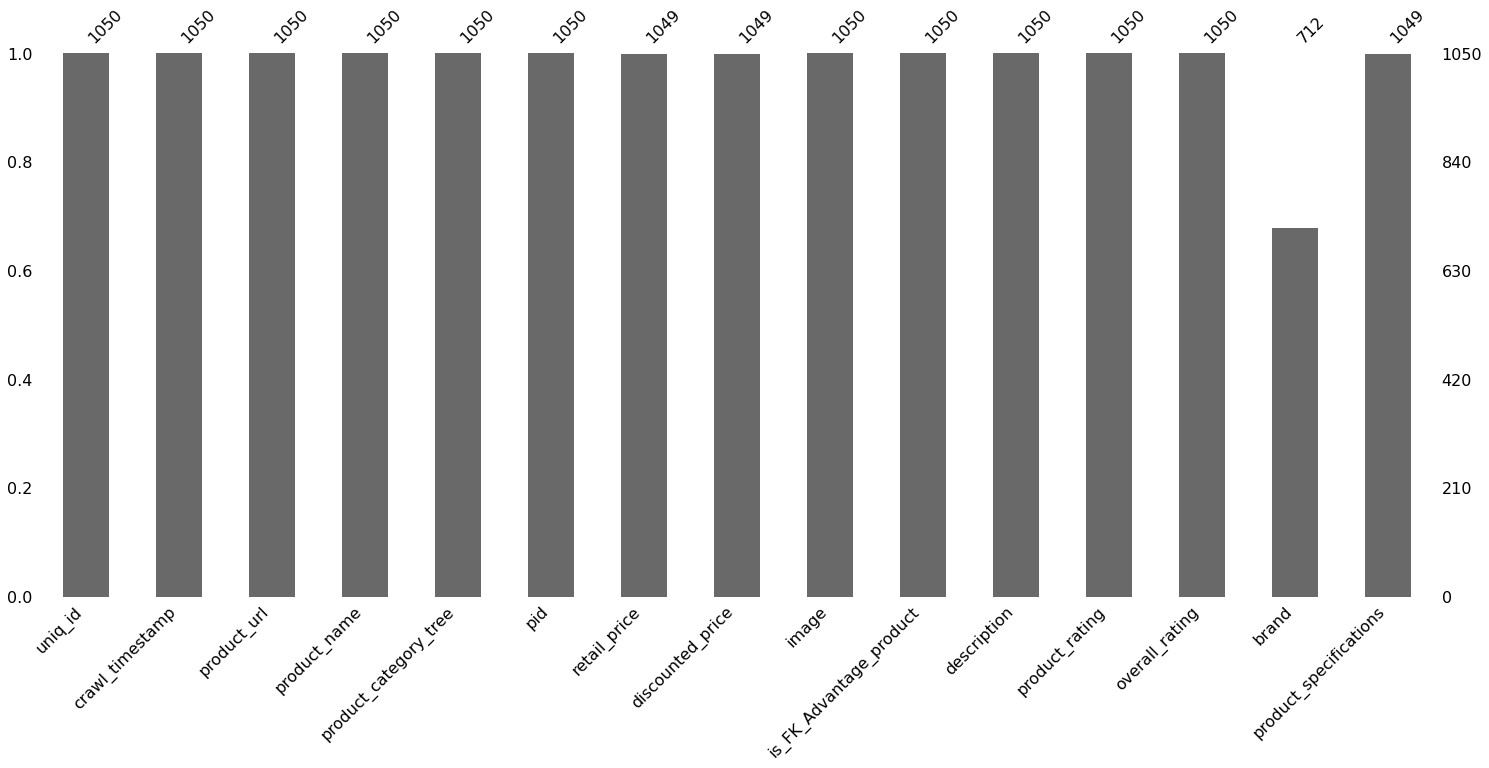

In [10]:
missingno.bar(data)

## Brand

In [11]:
brand_unique = data['brand'].nunique()
print(f'{brand_unique} brands uniques')


490 brands uniques


## Ratings

In [12]:
fig = make_subplots(rows=1, cols=2, subplot_titles=
                    ('Product ratings', 'Overall ratings'),
                    specs=[[{"type": "domain"}, {"type": "domain"}]])

fig.add_trace(go.Pie(labels=data['product_rating']), row=1, col=1)
fig.add_trace(go.Pie(labels=data['overall_rating']), row=1, col=2)


fig.update_layout(height=1500, showlegend=False)

fig.update_traces(hoverinfo='label+percent+value', textinfo='label+percent', textfont_size=12)


fig.show()

## Price

In [13]:
fig = make_subplots(rows=1, cols=2, subplot_titles=
                    ('Retail Price', 'Discount Price'))
fig.add_trace(go.Histogram(x=data['retail_price'], nbinsx=1000, name="Retail Price"), row=1, col=1)
fig.add_trace(go.Histogram(x=data['discounted_price'], nbinsx=1000, name="Discount Price"), row=1, col=2)

fig.show()

In [14]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=data['retail_price'], name="Retail price", nbinsx=1000))
fig.add_trace(go.Histogram(x=data['discounted_price'], name="Discount Price",nbinsx=1000))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [15]:
data[data['retail_price'] > 100000]

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
9,710ed5f2393a4b9e8823aa0029f71f93,2015-12-04 07:25:36 +0000,http://www.flipkart.com/tag-heuer-cau1116-ba08...,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,"[""Watches >> Wrist Watches >> TAG Heuer Wrist ...",WATEA6UGFGKZKDJC,107750.0,107750.0,710ed5f2393a4b9e8823aa0029f71f93.jpg,False,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp..."
11,08452abdadb3db1e686b94a9c52fc7b6,2015-12-04 07:25:36 +0000,http://www.flipkart.com/cartier-w6701005-analo...,"Cartier W6701005 Analog Watch - For Boys, Men","[""Watches >> Wrist Watches >> Cartier Wrist Wa...",WATEAK8SE2RUK7GM,201000.0,201000.0,08452abdadb3db1e686b94a9c52fc7b6.jpg,False,"Cartier W6701005 Analog Watch - For Boys, Men...",No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp..."


# Test

In [16]:
data

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.